In [6]:
import os
import functools
from itertools import groupby
import operator
from collections import defaultdict

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

#from dwave.system.samplers import DWaveSampler
#from dwave.system.composites import EmbeddingComposite
from Bio import SeqIO
from Bio import SeqIO

from codon_optimization import *

# <center> Graph of Codon Optimization Problems <center>

---
## 0. Build a Matrix

In [7]:
def H_cqm_matrix(h_codon, host='e_coli'):
    # 0. Weight Parameters
    wp = h_codon.wp

    # 1. Codon Usage Bias
    vec_cub = h_codon.vec_zeta(host)

    # 2. Codon Pair Usage Bias
    #print(host1, host2)    
    mat_cpub = h_codon.matrix_CPS(host)

    # 3. repeated nucleotide sequence
    mat_R = h_codon.matrix_R()    

    mat_total = (-1) * (wp['cpub_h1']*mat_cpub - wp['rep_nuc']*mat_R)
    vec_total = (-1) * wp['cub_h1']*vec_cub
    return vec_total, sp.sparse.csr_matrix(mat_total)

---
## 1. SPIKE SARS2 

In [8]:
name = 'SPIKE_SARS2 Spike glycoprotein'

sars_cov_protein = SeqIO.read("./SARS_Cov2_glycoprotein_YP_009724390_datasets/protein.faa", "fasta").seq
aa_seq = sars_cov_protein #[:700]

weight_params = {'cub_h1': 1, 'cpub_h1': 1, 'cub_h2': 0, 'cpub_h2': 0, 'rep_nuc': 0.75, 'rho_T': 0.5, 'B_rho': 0.4}
hosts = ['h_sapiens', 'sars_cov2']

In [17]:
sars_cov_protein

Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT')

In [11]:
H_codon = Codon_Hamiltonian(aa_seq, weight_params)
nodes_sars2spike, edges_sars2spike = H_cqm_matrix(H_codon, host=hosts[0])

### 1-2. Draw a Graph

In [12]:
#nodes_list = np.nonzero(nodes_sars2spike)[0]
nodes_list = range(len(nodes_sars2spike))
node_weights = 10*nodes_sars2spike

row, col, edge_weights = sp.sparse.find(sp.sparse.csr_matrix(edges_sars2spike))
edge_weights = edge_weights

print('Node')
print('Max:', max(node_weights), '\nMin:', min(node_weights))
print('\nEdge')
print('Max:', max(edge_weights), '\nMin:', min(edge_weights))

Node
Max: 29.957322735539908 
Min: -0.0

Edge
Max: 27.077617438670686 
Min: -0.8310968481870081


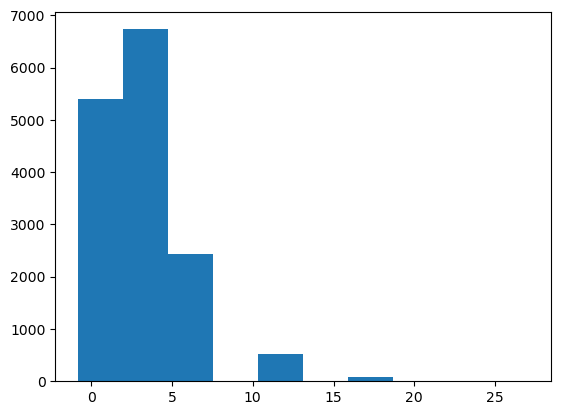

In [13]:
plt.hist(edge_weights)
plt.show()

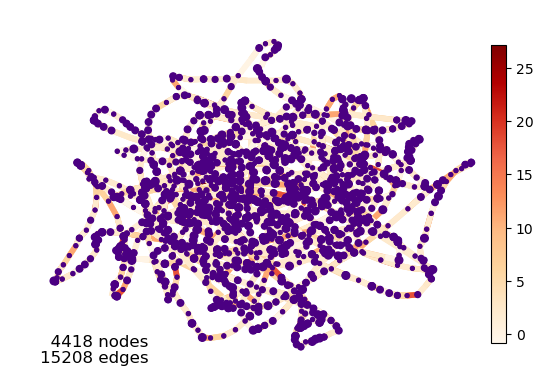

In [8]:
G = nx.Graph()
G.add_nodes_from(nodes_list)
G.add_edges_from(np.array([row, col]).T)
pos = nx.spring_layout(G, seed=100) #20


nodes = nx.draw_networkx_nodes(G, pos, node_size=node_weights, node_color='indigo') #,node_cmap=plt.cm.Blues)
edges = nx.draw_networkx_edges(
    G,
    pos,
    #node_size=20,
    edge_color=edge_weights,
    edge_cmap=plt.cm.OrRd,
    width=4,
)

#pc = mpl.collections.EventCollection(edges, cmap=cmap)
#pc.set_array(edge_colors)

plt.axis('off')
#plt.tight_layout()
plt.colorbar(edges, fraction=0.03, pad=-0.05)
plt.text(-1, -0.9, '  '+str(G.number_of_nodes())+' nodes', fontsize=12)
plt.text(-1, -1, str(G.number_of_edges())+' edges', fontsize=12)
plt.savefig("ising_sars2spike_human.png", dpi=1000)
plt.show()

In [15]:
G.number_of_nodes()

NameError: name 'G' is not defined

In [71]:
G.number_of_nodes(), G.number_of_edges()

(4418, 15208)

---
## 2. Insulin

### 2-1. Build a Matrix

In [8]:
name = 'Insulin'

insulin_human_protein = 'MALWMRLLPLLALLALWGPDPAAAFVNQHLCGSHLVEALYLVCGERGFFYTPKTRREAEDLQVGQVELGGGPGAGSLQPLALEGSLQKRGIVEQCCTSICSLYQLENYCN'
aa_seq = insulin_human_protein

weight_params = {'cub_h1': 0.02, 'cpub_h1': 0.6, 'cub_h2': 0, 'cpub_h2': 0, 'rep_nuc': 1, 'rho_T': 0.46, 'B_rho': 0.048}
hosts = ['e_coli', 'h_sapiens']

In [9]:
H_codon = Codon_Hamiltonian(aa_seq, weight_params)
nodes_insulin, edges_insulin = H_cqm_matrix(H_codon, host=hosts[0])

### 2-2. Draw a Graph

In [10]:
#nodes_list = np.nonzero(nodes_insulin)[0]
nodes_list = range(len(nodes_insulin))
node_weights = 300*nodes_insulin
#node_weights = 300*((-1)*min(nodes_insulin)+nodes_insulin)

row, col, edge_weights = sp.sparse.find(sp.sparse.csr_matrix(edges_insulin))
edge_weights = edge_weights

print('Node')
print('Max:', max(node_weights), '\nMin:', min(node_weights))
print('\nEdge')
print('Max:', max(edge_weights), '\nMin:', min(edge_weights))

Node
Max: 23.472138032568875 
Min: -0.0

Edge
Max: 35.71203399273892 
Min: -0.7250856477307076


(array([ 14.,  55.,  90.,  42.,  63., 111.,   2.,   5.,  25.,   5.]),
 array([ 0.        ,  2.3472138 ,  4.69442761,  7.04164141,  9.38885521,
        11.73606902, 14.08328282, 16.43049662, 18.77771043, 21.12492423,
        23.47213803]),
 <BarContainer object of 10 artists>)

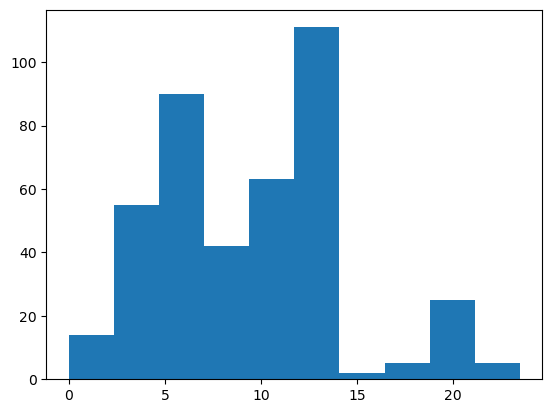

In [11]:
plt.hist(node_weights)

(array([644., 581., 239.,   0.,  62.,   0.,  10.,   4.,   0.,   3.]),
 array([-0.72508565,  2.91862632,  6.56233828, 10.20605024, 13.84976221,
        17.49347417, 21.13718614, 24.7808981 , 28.42461006, 32.06832203,
        35.71203399]),
 <BarContainer object of 10 artists>)

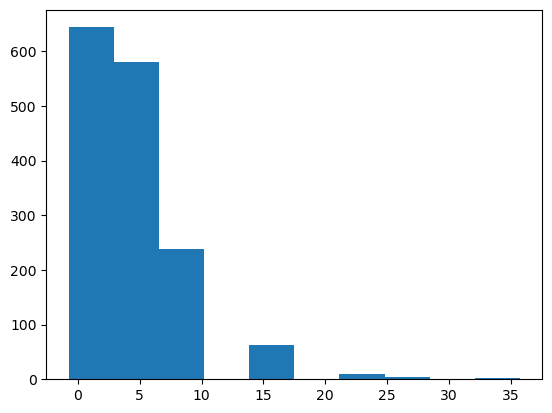

In [12]:
plt.hist(edge_weights)

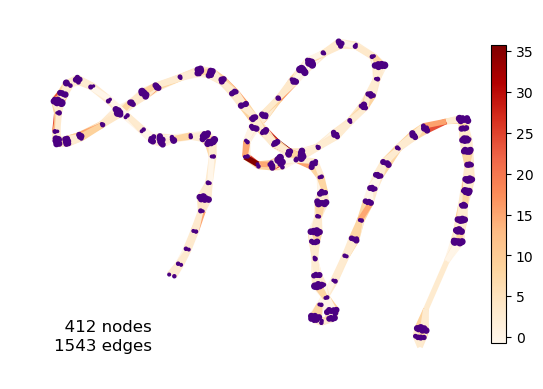

In [25]:
#plt.figure(figsize=(10, 10))
G = nx.Graph()
G.add_nodes_from(nodes_list)
G.add_edges_from(np.array([row, col]).T)
pos = nx.spring_layout(G, seed=91) #20, 27, 36, 40, 91, 100

nodes = nx.draw_networkx_nodes(G, pos, node_size=node_weights, node_color='indigo') #,node_cmap=plt.cm.Blues)
edges = nx.draw_networkx_edges(
    G,
    pos,
    #node_size=20,
    edge_color=edge_weights,
    edge_cmap=plt.cm.OrRd,
    width=4,
)

#pc = mpl.collections.EventCollection(edges, cmap=cmap)
#pc.set_array(edge_colors)

plt.axis('off')
#plt.tight_layout()
plt.colorbar(edges, fraction=0.03, pad=-0.05)
plt.text(-1, -0.9, '  '+str(G.number_of_nodes())+' nodes', fontsize=12)
plt.text(-1, -1, str(G.number_of_edges())+' edges', fontsize=12)
plt.savefig("ising_insulin_ecoli.png", dpi=1000)
plt.show()


TextBox <br> 
120 Nodes? 200 Edges?